In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx

In [15]:
from pygsp import graphs, filters, plotting, utils

In [16]:
# Create a random directed graph
G = nx.gnp_random_graph(100, 0.5, directed=True)
A = nx.to_numpy_array(G)

In [ ]:
# Reproducing Fig 2 in the magnetic Laplacian paper - (i.e. do we have an intuitive notion of frequency)

In [17]:
def total_variation(f, G):
    source, target, _ = G.get_edge_list()
    TV = 0
    for (s, t) in zip(source, target):
        TV += np.abs(f[s] - f[t])**2
    return TV

In [43]:
# Symmetrize, unweighted A laplacian, just for reference
Asym = 1/2 * (A + A.T)
Adj = 1 * Asym != 0
gref = graphs.Graph(Adj)

  (0, 0)	77.0
  (1, 1)	75.0
  (2, 2)	76.0
  (3, 3)	76.0
  (4, 4)	73.0
  (5, 5)	72.0
  (6, 6)	69.0
  (7, 7)	76.0
  (8, 8)	70.0
  (9, 9)	73.0
  (10, 10)	73.0
  (11, 11)	73.0
  (12, 12)	81.0
  (13, 13)	72.0
  (14, 14)	81.0
  (15, 15)	59.0
  (16, 16)	71.0
  (17, 17)	64.0
  (18, 18)	73.0
  (19, 19)	79.0
  (20, 20)	70.0
  (21, 21)	69.0
  (22, 22)	64.0
  (23, 23)	76.0
  (24, 24)	73.0
  :	:
  (75, 75)	79.0
  (76, 76)	77.0
  (77, 77)	76.0
  (78, 78)	74.0
  (79, 79)	73.0
  (80, 80)	70.0
  (81, 81)	79.0
  (82, 82)	76.0
  (83, 83)	67.0
  (84, 84)	75.0
  (85, 85)	77.0
  (86, 86)	82.0
  (87, 87)	77.0
  (88, 88)	69.0
  (89, 89)	76.0
  (90, 90)	74.0
  (91, 91)	76.0
  (92, 92)	74.0
  (93, 93)	78.0
  (94, 94)	74.0
  (95, 95)	70.0
  (96, 96)	66.0
  (97, 97)	65.0
  (98, 98)	79.0
  (99, 99)	75.0


(5.1203561466328884e-14+0j)


/home/akumar/anaconda3/envs/netcon/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.09366527273033629-1.1532587509287022e-16j)
(2.3220760668222216+1.2727118584663828e-15j)
(9.045842368334934+3.907636011123126e-16j)
(46.04833981784553+2.5486207401123005e-15j)
(55.410158686188936+1.1336681847394473e-30j)


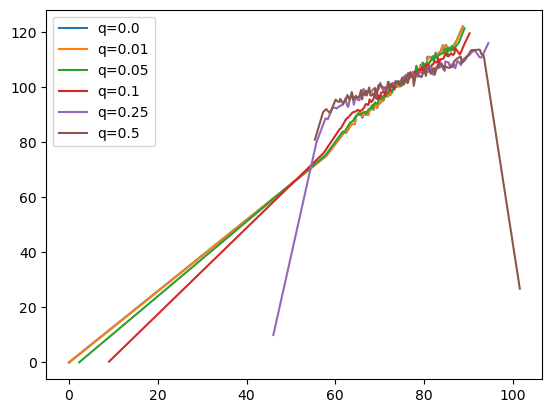

In [47]:
for q_ in np.array([0, 0.01, 0.05, 0.1 , 0.25, 0.5]):
    A = 1 * (A != 0)
    g = graphs.DiGraph(A, q=q_)
    eig, U = np.linalg.eig(g.L)
    print(np.min(eig))
    eig_order = np.argsort(eig)[::-1]
    eig = eig[eig_order]
    U = U[:, eig_order]

    TV = np.zeros(U.shape[1])
    for i in range(U.shape[1]):
        TV[i] = total_variation(U[:, i], g)

    plt.plot(eig, TV, label='q={}'.format(q_))

plt.legend()

In [88]:
G = nx.gnp_random_graph(50, 0.3, directed=True)
A = nx.to_numpy_array(G)

In [89]:
# Choose q = 0.05
g = graphs.DiGraph(A, q=q_)

In [120]:
# Assemble a cubic spline filter bank on the graph
fs = filters.Abspline(g, 6)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Abspline(in=1, out=6, lpfactor=20.00)'}, xlabel="laplacian's eigenvalues (graph frequencies) $\\lambda$", ylabel='filter response $g(\\lambda)$'>)

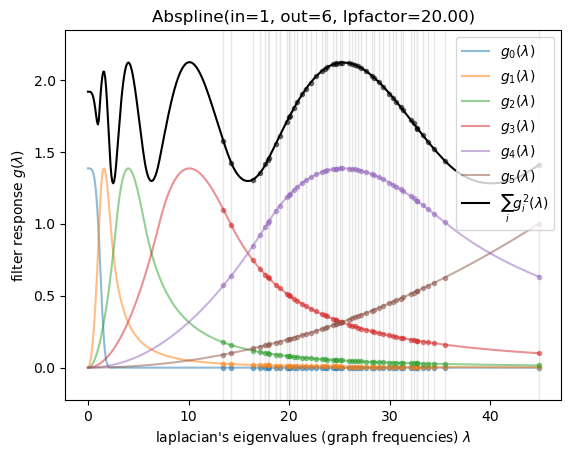

In [121]:
fs.plot()

In [137]:
fs.G.N

500

In [148]:
# Localize the filters around each node of the graph and return
def construct_wavelet_frame(fs):
    n = fs.Nf
    N = fs.G.N

    W = np.zeros((N, N, n))
    for i in range(N):
        s = fs.localize(i)
        W[i, ...] = s

    return W.transpose(0, 2, 1)


In [145]:
fs.estimate_frame_bounds()

(0.6865051158973686, 1.9944672373155525)

In [146]:
# Initialize a random signal over the graph and calculate the reconstruction coefficients
sig = np.random.randn(fs.G.N)

In [149]:
W = construct_wavelet_frame(fs)

In [150]:
W.shape

(500, 5, 500)

In [151]:
def project_signal(sig, W):
    beta = np.zeros((W.shape[0], W.shape[1]))
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            beta[i, j] = W[i, j, :] @ sig

    return beta 

In [152]:
coeff = project_signal(sig, W)

In [155]:
fs.estimate_frame_bounds()

(0.6865051158973686, 1.9944672373155525)

In [154]:
np.linalg.norm(coeff)**2/np.linalg.norm(sig)**2

725.6821879275028

In [105]:
s = fs.localize(1, method='exWact')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'DiGraph(n_vertices=50, n_edges=752)'}>)

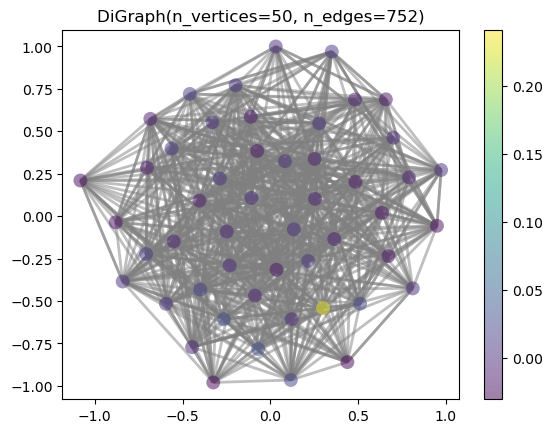

In [115]:
g.set_coordinates()
g.plot(np.real(s[:,7]))

In [119]:
fs.estimate_frame_bounds()

(1.2810260471808417, 2.123018286801947)

In [127]:
# Reproduce the swiss roll example from the original spectral graph wavelet paper
g = graphs.SwissRoll(500)
g.compute_fourier_basis()

In [128]:
fs = filters.Abspline(g, 5)

In [129]:
s = fs.localize(1, method='exact')

In [126]:
g.set_coordinates()

(<Figure size 640x480 with 2 Axes>,
 <Axes3D: title={'center': 'SwissRoll(n_vertices=500, n_edges=3555, a=1, b=4, ...)'}>)

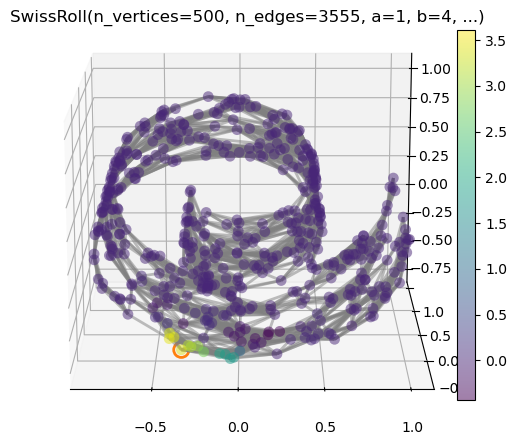

In [135]:
g.plot(s[:, 0], highlight=1)

In [ ]:
# One approach: one can use polynomial filters, as these will be necessary localized in the vertex domain.